<a href="https://colab.research.google.com/github/ahmetbekir22/LungAndColonCancerClassification/blob/main/LungAndColonCancerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ahmetbekir","key":"188396df721af1ed1591920fdfd9ec24"}'}

In [12]:
import kaggle
from io import BytesIO
from zipfile import ZipFile
import pandas as pd

dataset = kaggle.api.dataset_download_files('andrewmvd/lung-and-colon-cancer-histopathological-images', unzip=False)


Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images


In [13]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os

In [14]:
import zipfile

zip_path = './lung-and-colon-cancer-histopathological-images.zip'
extract_to = './lung_colon_image_set'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(os.listdir(extract_to))


['lung_colon_image_set']


In [16]:
train_dir = './lung_colon_image_set/lung_colon_image_set/lung_image_sets'
test_dir = './lung_colon_image_set/lung_colon_image_set/colon_image_sets'


# Data Augmantation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [19]:


# DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

for layer in base_model.layers:
    layer.trainable = False


In [20]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 263s 626ms/step - accuracy: 0.8689 - loss: 0.3527 - val_accuracy: 0.9527 - val_loss: 0.1277
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 256s 675ms/step - accuracy: 0.9510 - loss: 0.1342 - val_accuracy: 0.9467 - val_loss: 0.1267
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 216s 570ms/step - accuracy: 0.9546 - loss: 0.1226 - val_accuracy: 0.9463 - val_loss: 0.1311
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 219s 574ms/step - accuracy: 0.9573 - loss: 0.1058 - val_accuracy: 0.9607 - val_loss: 0.0981
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 261s 573ms/step - accuracy: 0.9603 - loss: 0.1001 - val_accuracy: 0.9637 - val_loss: 0.0910
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 216s 569ms/step - accuracy: 0.9646 - loss: 0.0910 - val_accuracy: 0.9587 - val_loss: 0.1014
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 219s 575ms/step - accuracy: 0.9658 - loss: 0.0867 - val_accuracy: 0.9553 - val_loss: 0.1031
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 215s 566ms/step - accuracy: 0.9632 - loss: 0.09

In [21]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 42s 451ms/step - accuracy: 0.9613 - loss: 0.0972
Validation Loss: 0.09268349409103394
Validation Accuracy: 0.9620000123977661


In [24]:
test_generator = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

predictions = model.predict(test_generator)


Found 10000 images belonging to 2 classes.
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 158ms/step


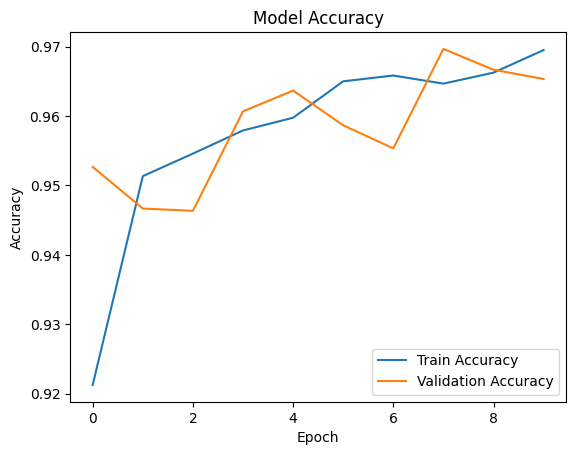

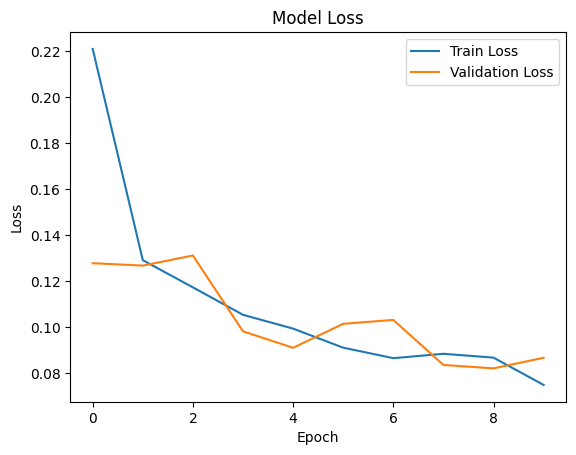

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.show()
